Now we are going to go and standardise and normalise these images using this resizing and normalisation matrix.

In [10]:
from torchvision import transforms

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

We are now going to load some DNNs


In [11]:
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm   # For progress bar
from PIL import ImageFile

# allow partially read images instead of failing
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define transforms and device
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Prepare Model (remove final layer for features)
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*(list(resnet.children())[:-1]))  # outputs [batch, 2048, 1, 1]
model.eval()
model.to(device)

def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()

dataset = datasets.ImageFolder("data/cats-and-dogs", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_features = []
train_labels = []

for imgs, labels in tqdm(loader, desc="Extracting features"):
    batch_feats = extract_features(imgs)
    train_features.append(batch_feats)
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Feature vectors shape:", train_features.shape)
print("Labels shape:", train_labels.shape)

Using device: cuda


Extracting features:  95%|█████████▍| 740/780 [00:17<00:00, 42.66it/s]/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Extracting features: 100%|██████████| 780/780 [00:18<00:00, 41.84it/s]



Feature vectors shape: (24959, 2048)
Labels shape: (24959,)


Now we will try a few methods of dimensionality reduction.
We will use T-SNE, PCA and UMAP and compare results.

/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


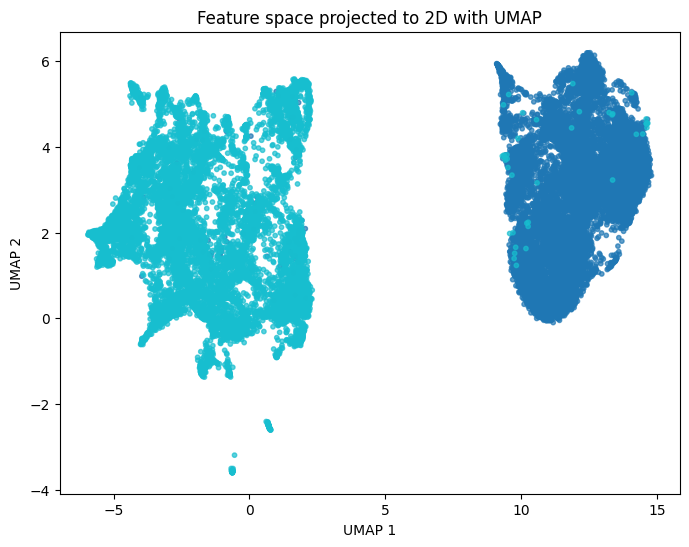

In [12]:
import matplotlib.pyplot as plt
import umap


reducer = umap.UMAP(n_components=2, random_state=67)
features_2D_UMAP = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Feature space projected to 2D with UMAP")
plt.show()



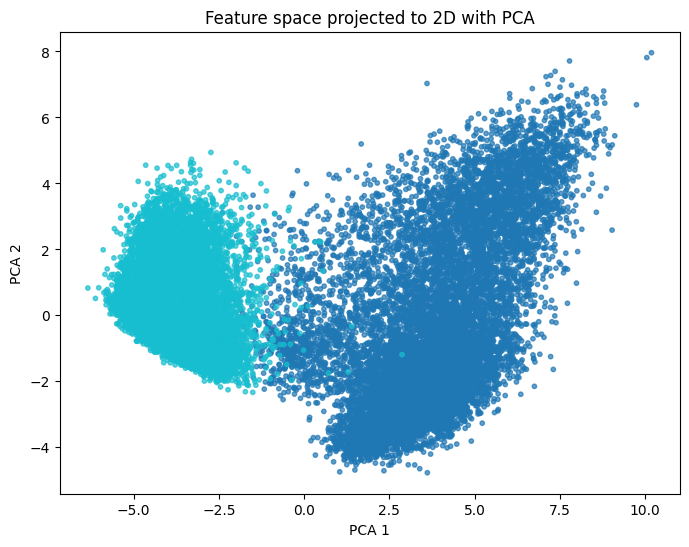

In [13]:
import sklearn.decomposition
from sklearn.decomposition import PCA


reducer = PCA(n_components=2)
features_2D_PCA = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Feature space projected to 2D with PCA")
plt.show()

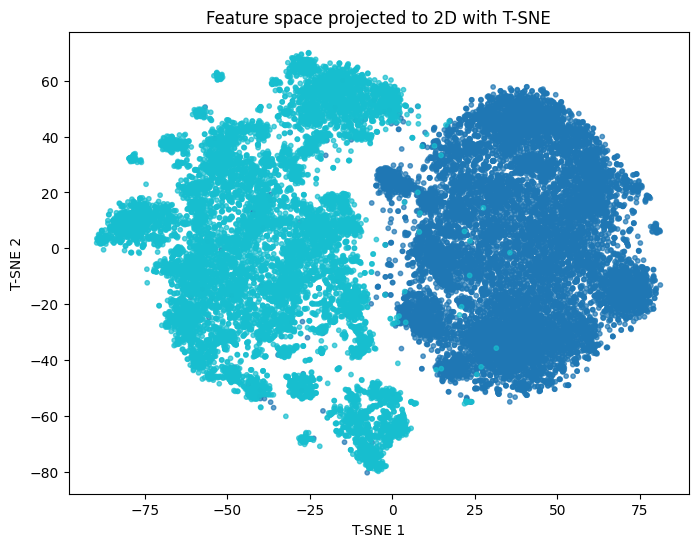

In [14]:
#t-sne



from sklearn.manifold import TSNE


reducer = TSNE(n_components=2, random_state=67)
features_2D_TSNE = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("T-SNE 1")
plt.ylabel("T-SNE 2")
plt.title("Feature space projected to 2D with T-SNE")
plt.show()

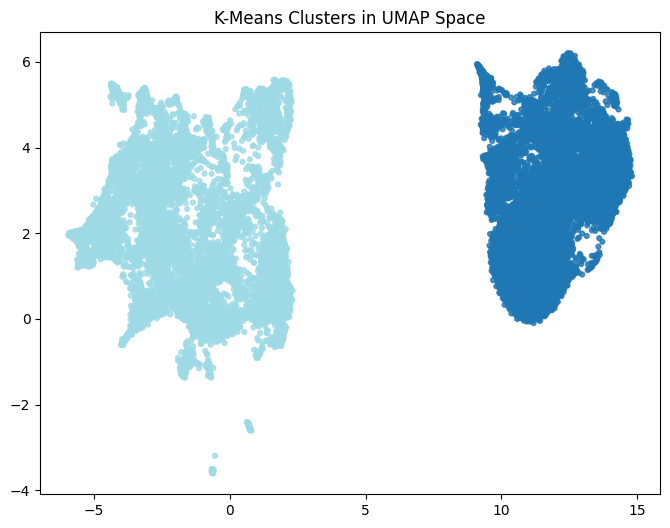

In [15]:
from sklearn.cluster import KMeans

n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_UMAP)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in UMAP Space')
plt.show()

In [16]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

db_score = davies_bouldin_score(features_2D_UMAP, cluster_labels)
sil_score = silhouette_score(features_2D_UMAP, cluster_labels)
print("Davies-Bouldin Index:", db_score)
print("Silhouette Score:", sil_score)

Davies-Bouldin Index: 0.3440170515519504
Silhouette Score: 0.7631113529205322


/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Saved classifier
Test accuracy: 0.9941907051282052
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      2498
         Dog       0.99      0.99      0.99      2494

    accuracy                           0.99      4992
   macro avg       0.99      0.99      0.99      4992
weighted avg       0.99      0.99      0.99      4992



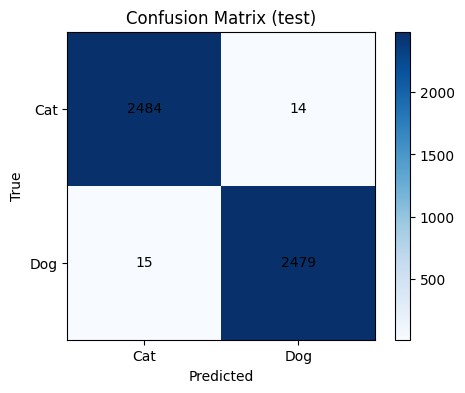

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib


x_train, x_test, y_train, y_test = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=67, stratify=train_labels
)


clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, multi_class="multinomial", solver="lbfgs", random_state=67))

clf.fit(x_train, y_train)

joblib.dump(clf, "catsanddogsmodel1.joblib")
print("Saved classifier")


y_test_pred = clf.predict(x_test)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=dataset.classes))


# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test)')
# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:d}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.show()